In [1]:
import sys 
sys.path.append('..')

import pandas as pd

from helpers.lift import area_ratio_scorer, area_ratio, plot_lift_chart

df = pd.read_csv('../data/engineered.csv')
df.head()

,Unnamed: 0,X1,X3,X5,X6,X7,X8,X9,X10,X11,...,payment_total,payment_avg,payment_std,payment_max,payment_min,payment_growth,payment_trend,payment_zero_count,payment_all_zero,payment_low_count
0,0,20000,2,24,2,2,-1,-1,-2,-2,...,689,114.833336,281.28308,689,0,0,59.057144,5,0,6
1,1,120000,2,26,-1,2,0,0,0,2,...,5000,833.333300,752.77264,2000,0,-2000,-200.000000,2,0,2
2,2,90000,2,34,0,0,0,0,0,0,...,11018,1836.333400,1569.81540,5000,1000,-3482,-454.571440,0,0,0
3,3,50000,2,37,0,0,0,0,0,0,...,8388,1398.000000,478.05817,2019,1000,1000,227.142850,0,0,0
4,4,50000,2,57,-1,0,-1,0,0,0,...,59049,9841.500000,13786.23000,36681,679,1321,3302.314200,0,0,2


In [2]:
from sklearn.model_selection import train_test_split 

X = df.drop('Y', axis=1)
y = df["Y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

optim_gnb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
      ("pca", PCA(svd_solver="full")),
    ('optim_gnb_clf', GaussianNB())
])

param_grid = {
    'optim_gnb_clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
    'optim_gnb_clf__priors': [[0.5, 0.5], [0.6, 0.4]] 
}

grid_search_nb = GridSearchCV(
    estimator=optim_gnb_pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=area_ratio_scorer,
    n_jobs=-1,
    verbose=2
)

grid_search_nb.fit(X_train, y_train)

print("Best Params:", grid_search_nb.best_params_)
print("Best Score:", grid_search_nb.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.1s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.2s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.1s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.1s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.3s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-08; total time=   0.2s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.2s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-09; total time=   0.2s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_clf__var_smoothing=1e-08; total time=   0.2s
[CV] END optim_gnb_clf__priors=[0.5, 0.5], optim_gnb_cl

Best Params: {'optim_gnb_clf__priors': [0.6, 0.4], 'optim_gnb_clf__var_smoothing': 0.0001}
Best Score: 0.47659347648130534

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

import numpy as np


optimized_gnb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
      ("pca", PCA(svd_solver="full")),
    ('optimized_gnb_clf', GaussianNB(priors=[0.6, 0.4], var_smoothing=0.0001))
])

optimized_gnb_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'full'


In [5]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred_optimized = optimized_gnb_pipeline.predict(X_train)
y_train_proba_optimized = optimized_gnb_pipeline.predict_proba(X_train)[:, 1]

y_test_pred_optimized = optimized_gnb_pipeline.predict(X_test)
y_test_proba_optimized = optimized_gnb_pipeline.predict_proba(X_test)[:, 1]

train_optimized_error = 1 - accuracy_score(y_train, y_train_pred_optimized)
train_optimized_area = area_ratio(y_train, y_train_proba_optimized)

test_optimized_error = 1 - accuracy_score(y_test, y_test_pred_optimized)
test_optimized_area = area_ratio(y_test, y_test_proba_optimized)

In [6]:
print(f'TRAIN: Error Rate {train_optimized_error:.4f}\n')
print(f'TRAIN: Area Ratio {train_optimized_area:.4f}\n')
print("TRAIN: Classification Report")
print(classification_report(y_train, y_train_pred_optimized, digits=4, zero_division=0))

TRAIN: Error Rate 0.2855

TRAIN: Area Ratio 0.4483

TRAIN: Classification Report
              precision    recall  f1-score   support

           0     0.8679    0.7477    0.8033     16357
           1     0.4004    0.5968    0.4793      4618

    accuracy                         0.7145     20975
   macro avg     0.6341    0.6722    0.6413     20975
weighted avg     0.7649    0.7145    0.7320     20975



In [7]:
print(f'TEST: Error Rate {test_optimized_error:.4f}\n')
print(f'TEST: Area Ratio {test_optimized_area:.4f}\n')
print("TEST: Classification Report")
print(classification_report(y_test, y_test_pred_optimized, digits=4, zero_division=0))

TEST: Error Rate 0.2812

TEST: Area Ratio 0.4394

TEST: Classification Report
              precision    recall  f1-score   support

           0     0.8608    0.7607    0.8077      6978
           1     0.4086    0.5736    0.4773      2012

    accuracy                         0.7188      8990
   macro avg     0.6347    0.6671    0.6425      8990
weighted avg     0.7596    0.7188    0.7337      8990



In [8]:
import numpy as np

# Sort by highest predicted risk
sorted_idx = np.argsort(-y_test_proba_optimized)  # descending order
y_true_sorted = y_test.iloc[sorted_idx].reset_index(drop=True)  # sorted ground truth


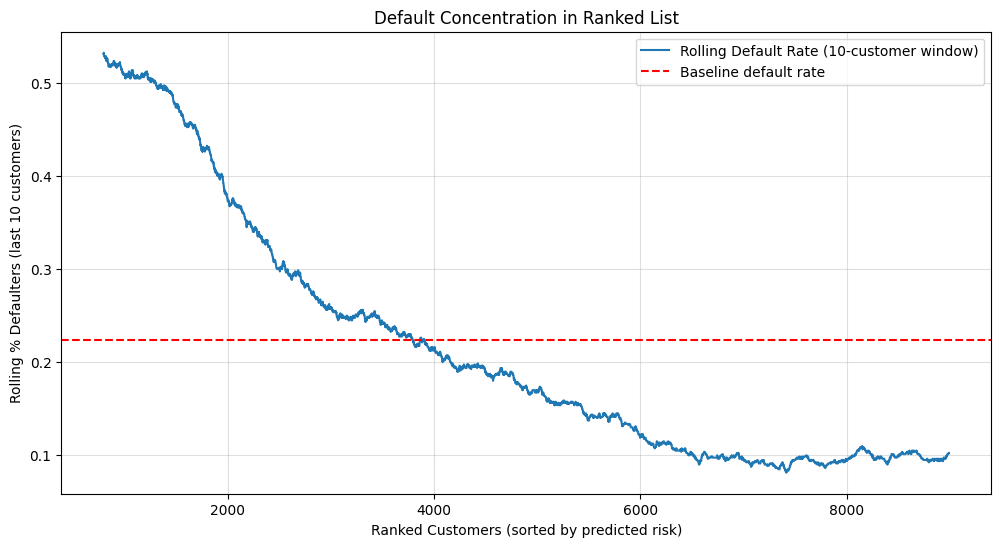

In [9]:
import matplotlib.pyplot as plt

window_size = 800  # rolling over 10 customers
rolling_default_rate = y_true_sorted.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))

plt.plot(
    rolling_default_rate.values,
    label="Rolling Default Rate (10-customer window)"
)

# Baseline average default rate in test set
plt.axhline(y=y_test.mean(), color="red", linestyle="--", label="Baseline default rate")

plt.xlabel("Ranked Customers (sorted by predicted risk)")
plt.ylabel("Rolling % Defaulters (last 10 customers)")
plt.title("Default Concentration in Ranked List")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [10]:
import pandas as pd
import numpy as np

# Total number of customers
n = len(y_true_sorted)

# Total defaults
total_defaults = y_true_sorted.sum()

decile_results = []

# For each decile (10%, 20%, ..., 100%)
for d in range(5, 110, 5):
    cutoff = int((d/100) * n)  # number of customers in top d%
    captured_defaults = y_true_sorted.iloc[:cutoff].sum()
    captured_pct = (captured_defaults / total_defaults) * 100
    decile_results.append({"Top % Population": f"Top {d}%", 
                           "Defaults Captured (%)": round(captured_pct, 2)})

# Create table
decile_df = pd.DataFrame(decile_results)
print(decile_df)


   Top % Population  Defaults Captured (%)
0            Top 5%                  12.18
1           Top 10%                  23.46
2           Top 15%                  34.34
3           Top 20%                  42.84
4           Top 25%                  49.95
5           Top 30%                  55.86
6           Top 35%                  61.23
7           Top 40%                  66.40
8           Top 45%                  70.83
9           Top 50%                  75.15
10          Top 55%                  78.53
11          Top 60%                  82.06
12          Top 65%                  84.74
13          Top 70%                  86.98
14          Top 75%                  88.87
15          Top 80%                  90.95
16          Top 85%                  93.24
17          Top 90%                  95.33
18          Top 95%                  97.66
19         Top 100%                 100.00
20         Top 105%                 100.00


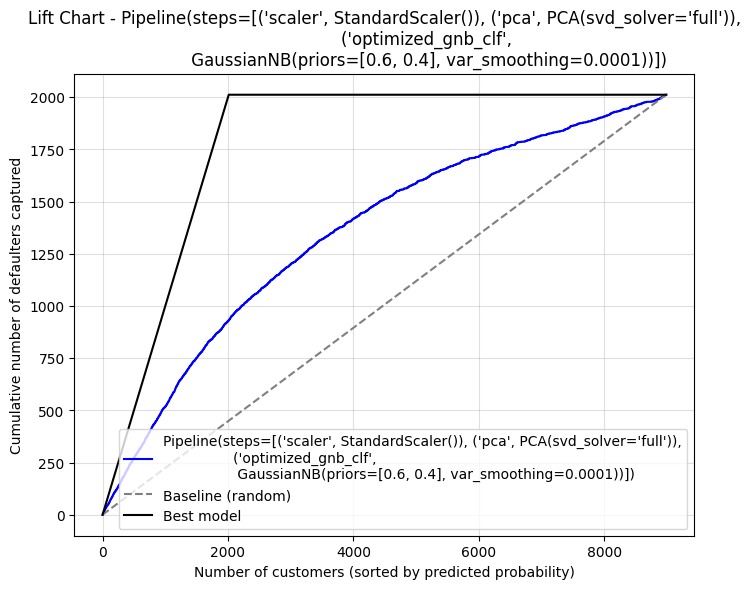

In [11]:
plot_lift_chart(y_test, y_test_proba_optimized, optimized_gnb_pipeline)